In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

from datetime import datetime, timedelta, date
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg,ar_select_order

In [139]:
# Read the data and set the index to datetime

df = pd.read_csv("data/temp_data.txt", index_col=1, parse_dates = True)
df.index = pd.to_datetime(df.index)

In [140]:
# the column names in the original csv are not very self explanatory. We'll rename them for clarity
# temperatures also need to be scaled

df.rename(columns={' SOUID':'id', '   TG':'temp', ' Q_TG':'quality'}, inplace= True)
df.temp = df.temp / 10

In [141]:
df.dtypes

id           int64
temp       float64
quality      int64
dtype: object

In [142]:
df.describe()

,id,temp,quality
count,53507.000000,53507.000000,53507.000000
mean,119335.479844,5.720921,0.032818
std,8023.477558,61.325550,0.542349
min,111448.000000,-999.900000,0.000000
25%,111448.000000,3.300000,0.000000
50%,111448.000000,9.400000,0.000000
75%,127488.000000,15.700000,0.000000
max,128124.000000,30.500000,9.000000


There are no missing values, however it does seem like the minimum temperature does not make sense

In [143]:
df[df['quality'] == 9].value_counts()

id      temp    quality
127488  -999.9  9          195
dtype: int64

It looks like in any row with quality = 9 (data missing), the data for temperature has been filled in as -999

In [244]:
# We now know we have wrong data for the rows with 'quality' == 9. 
# We want to replace these data with data from the year before

def replace_missing_temp(date):
    print(date)
    date_one_year_ago = date - timedelta(days=365)
    print(date_one_year_ago)
    date = pd.to_datetime(date)
    date_one_year_ago = pd.to_datetime(date_one_year_ago)
    
    if pd.to_datetime(date_one_year_ago) in df.index:
        df['temp'].loc[date] = df['temp'].loc[date_one_year_ago]
    else:
        print('Could NOT find date')

# we select the rows we're interested in applying our function to
index = df[df['quality'] == 9].index

# and we apply!

for date in index:
    replace_missing_temp(date)

1945-04-25 00:00:00
1944-04-25 00:00:00


/var/folders/lc/5g5qpj5s2vsgnmfrzd3k26y80000gn/T/ipykernel_57911/1476615480.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'].loc[date] = df['temp'].loc[date_one_year_ago]


1945-04-26 00:00:00
1944-04-26 00:00:00
1945-04-27 00:00:00
1944-04-27 00:00:00
1945-04-28 00:00:00
1944-04-28 00:00:00
1945-04-29 00:00:00
1944-04-29 00:00:00
1945-04-30 00:00:00
1944-04-30 00:00:00
1945-05-01 00:00:00
1944-05-01 00:00:00
1945-05-02 00:00:00
1944-05-02 00:00:00
1945-05-03 00:00:00
1944-05-03 00:00:00
1945-05-04 00:00:00
1944-05-04 00:00:00
1945-05-05 00:00:00
1944-05-05 00:00:00
1945-05-06 00:00:00
1944-05-06 00:00:00
1945-05-07 00:00:00
1944-05-07 00:00:00
1945-05-08 00:00:00
1944-05-08 00:00:00
1945-05-09 00:00:00
1944-05-09 00:00:00
1945-05-10 00:00:00
1944-05-10 00:00:00
1945-05-11 00:00:00
1944-05-11 00:00:00
1945-05-12 00:00:00
1944-05-12 00:00:00
1945-05-13 00:00:00
1944-05-13 00:00:00
1945-05-14 00:00:00
1944-05-14 00:00:00
1945-05-15 00:00:00
1944-05-15 00:00:00
1945-05-16 00:00:00
1944-05-16 00:00:00
1945-05-17 00:00:00
1944-05-17 00:00:00
1945-05-18 00:00:00
1944-05-18 00:00:00
1945-05-19 00:00:00
1944-05-19 00:00:00
1945-05-20 00:00:00
1944-05-20 00:00:00


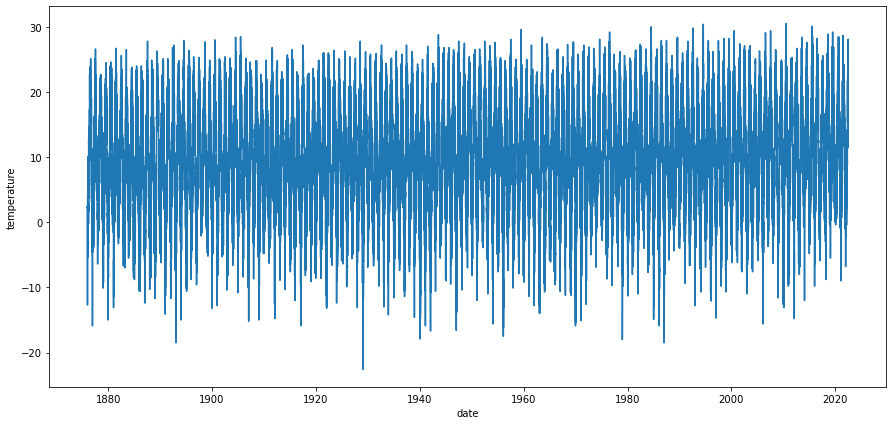

In [145]:
# we can now model our temperature data over time

plt.figure(figsize=(15,7))
plt.plot(df.index, df['temp'])
plt.xlabel('date')
plt.ylabel('temperature');

## Modeling trend

In [146]:
# We add our timestep column

df['timestep'] = list(range(len(df)))

In [147]:
# We create our test and train datasets. We'll use the last year as the validation dataset

df_train = df[:-365]

X_train = df_train[['timestep']]
y_train = df_train['temp']

df_test = df[-365:]

X_test = df_test[['timestep']]
y_test = df_test['temp']

In [148]:
LR = LinearRegression()

In [149]:
LR.fit(X_train, y_train)
y_pred = LR.predict(X_train)

In [150]:
LR.score(X_train, y_train), LR.score(X_test, y_test)

(0.004031963937985772, -0.022600750149249338)

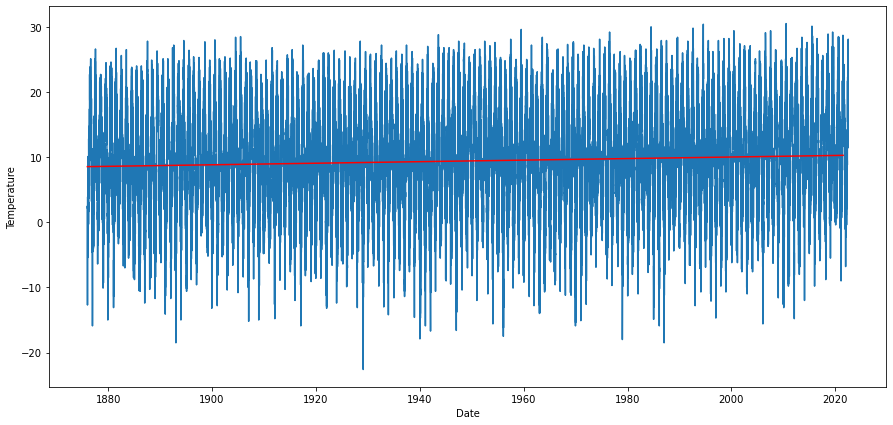

In [151]:
# now we can model our trend!

plt.figure(figsize=(15,7))
plt.plot(df.index, df.temp)
plt.plot(X_train.index, y_pred, color="red")
plt.xlabel('Date')
plt.ylabel('Temperature');

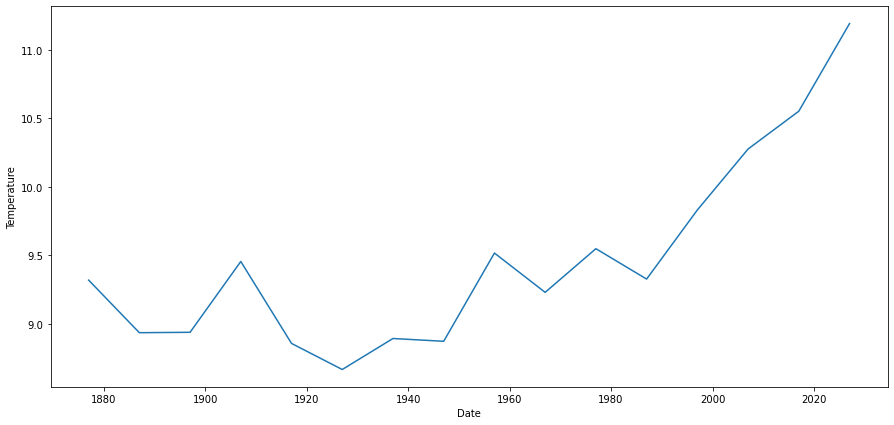

In [221]:
# it's quite hard to see the overall trend from the graph above so we'll resample to a longer period

df_by_year = df.resample('10Y').mean()

plt.figure(figsize=(15,7))
plt.plot(df_by_year.index, df_by_year.temp)
#plt.plot(X_train.index, y_pred, color="red")
plt.xlabel('Date')
plt.ylabel('Temperature');

## Modeling trend + seasonality

In [152]:
# We can model seasonality based on month dummies. We'll create a function we can apply to both train and test

def add_seasonal_dummies(dataframe):
    seasonal_dummies = pd.get_dummies(dataframe.index.month, prefix='month').set_index(dataframe.index)

    dataframe = dataframe.join(seasonal_dummies)
    return dataframe

In [153]:
X_train = add_seasonal_dummies(X_train)
X_test = add_seasonal_dummies(X_test)

### CHANGE M TO LR

In [154]:
#m = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [155]:
# we create a new column to store seasonal data. This column will be useful when calculating the remainder

def add_seasonal_and_sort(dataframe): 
    
    dataframe['seasonal'] = LR.predict(dataframe)
    #dataframe.sort_index(inplace=True)
    
add_seasonal_and_sort(X_train)
add_seasonal_and_sort(X_test)

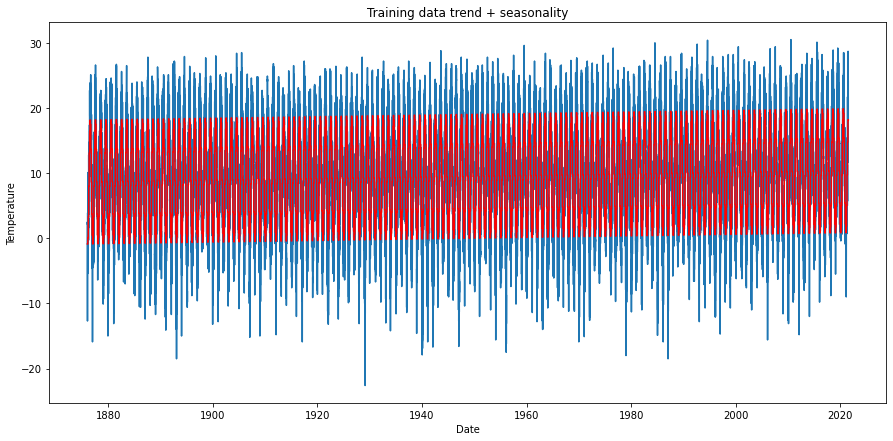

In [156]:
# and now we plot our train dataset trend + seasonality

plt.figure(figsize=(15,7))
plt.plot(X_train.index, y_train)
plt.plot(X_train.index, X_train.seasonal, color="red")
plt.title('Training data trend + seasonality')
plt.xlabel('Date')
plt.ylabel('Temperature');

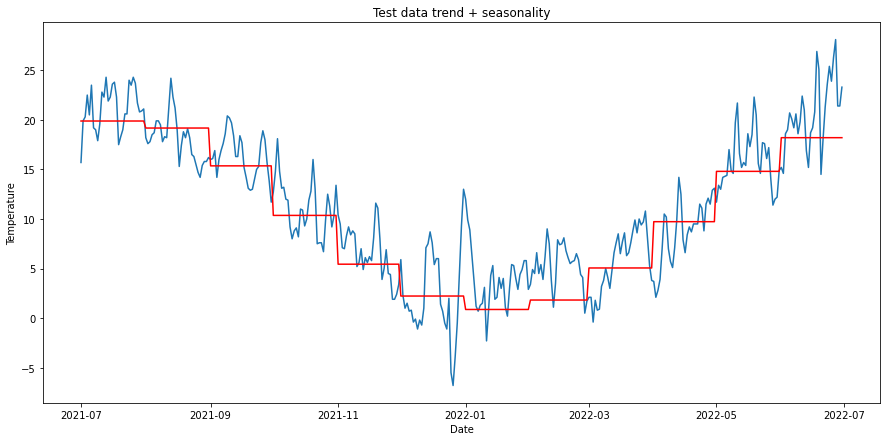

In [157]:
# we can also plot our trend + seasonality on the test dataset

plt.figure(figsize=(15,7))
plt.plot(X_test.index, y_test)
plt.plot(X_test.index, X_test.seasonal, color="red")
plt.title('Test data trend + seasonality')
plt.xlabel('Date')
plt.ylabel('Temperature');

## Modeling the remainder

In [158]:
# the remainder is the substraction of seasonality and trend from th true values. 
# Therefore, we need to be able to access y values and seasonal values
# We'll join the y values to the dataframe to make this easy

df_with_seasonal = X_train.join(y_train)
df_with_seasonal_test = X_test.join(y_test)

In [159]:
df_with_seasonal_test.head()

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal,temp
DATE,,,,,,,,,,,,,,,
2021-07-01,53142,0,0,0,0,0,0,1,0,0,0,0,0,19.883296,15.7
2021-07-02,53143,0,0,0,0,0,0,1,0,0,0,0,0,19.883329,19.9
2021-07-03,53144,0,0,0,0,0,0,1,0,0,0,0,0,19.883361,20.3
2021-07-04,53145,0,0,0,0,0,0,1,0,0,0,0,0,19.883394,22.5
2021-07-05,53146,0,0,0,0,0,0,1,0,0,0,0,0,19.883427,20.5


In [160]:
# now we calculate the remainder for each row and store it in a new column

def make_remainder_column(dataframe):
    dataframe['remainder'] = dataframe['temp'] - dataframe['seasonal']
    return dataframe

make_remainder_column(df_with_seasonal)
make_remainder_column(df_with_seasonal_test);

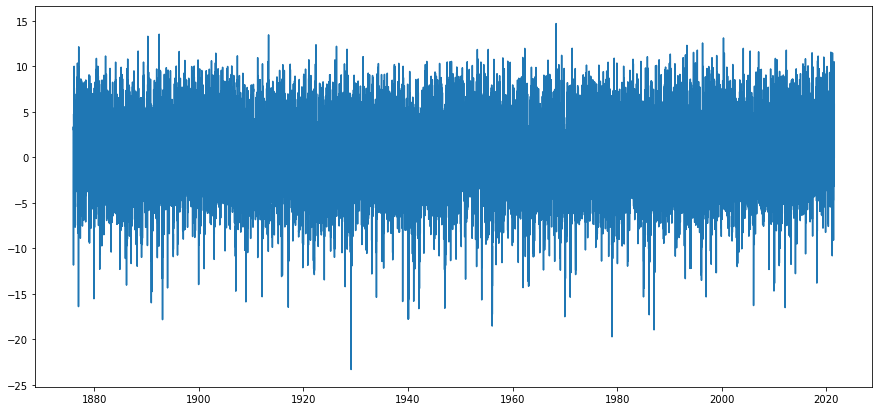

In [161]:
# we can now plot the remainder
plt.figure(figsize=(15,7))
plt.plot(df_with_seasonal.index, df_with_seasonal['remainder'])

In [162]:
# now that we have the remainder, we can use ar_select_order to find the optimal number of lags

selected_order = ar_select_order(df_with_seasonal['remainder'], maxlag=12)
lag_list = selected_order.ar_lags
lag_list

# looks like it's 4!

/Users/em/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/em/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[1, 2, 3, 4]

In [163]:
# looks like the optimal lag number is 4! Meaning we need 4 lag columns to help us make the full predictions

def add_lag_column(dataframe, list_of_lags):
    for number in list_of_lags:
        dataframe['lag' + str(number)] = dataframe['remainder'].shift(number)
        #dataframe.dropna(inplace=True)
    return dataframe

add_lag_column(df_with_seasonal, lag_list)
add_lag_column(df_with_seasonal_test, lag_list);

In [164]:
#We can't do predictions with NaN values so we'll drop the first 4 days of our training set

df_with_seasonal.dropna(inplace=True)

In [165]:
df_with_seasonal.head(2)

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal,temp,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,,,
1876-01-05,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.871318,-9.8,-8.928682,-4.928650,1.171383,3.371415,3.071448
1876-01-06,5,1,0,0,0,0,0,0,0,0,0,0,0,-0.871285,-7.7,-6.828715,-8.928682,-4.928650,1.171383,3.371415


In [166]:
# we now have all the columns we need to make our final predictions! 
# we'll drop the columns with predictions so that we can only keep our timestep, month dummies and lag columns

X_train = df_with_seasonal.drop(columns=['temp', 'seasonal', 'remainder'])
y_train = df_with_seasonal['temp']

X_test = df_with_seasonal_test.drop(columns=['temp', 'seasonal', 'remainder'])
y_test = df_with_seasonal_test['temp']

In [167]:
LR.fit(X_train, y_train)

LinearRegression()

In [168]:
df_with_seasonal['full_predictions'] = LR.predict(X_train)

In [169]:
LR.score(X_train, y_train)

# can't predict test yet as there are NaN values in the lag columns

0.9139267393560621

In [170]:
# let's sort the index so we can see our dataframe in date order

df_with_seasonal.sort_index()
df_with_seasonal_test.sort_index();

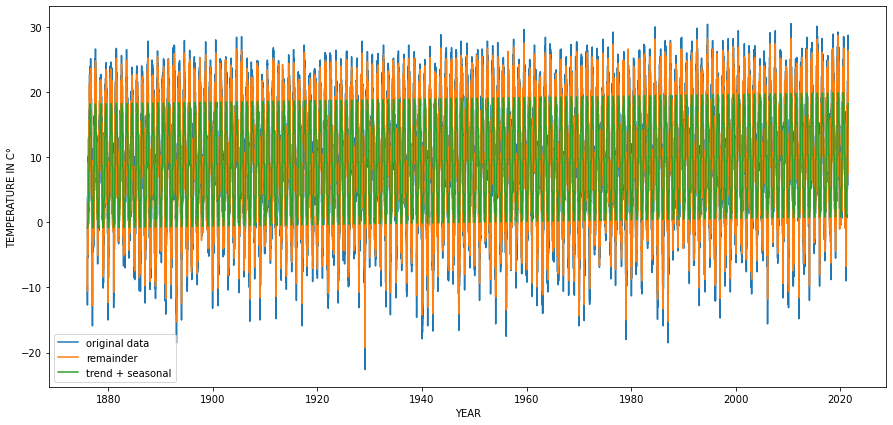

In [171]:
# now we can plot seasonality + trend AND remainder. Good news, our plot seems to almost match the original data in blue!

plt.figure(figsize=(15,7))
plt.plot(df_with_seasonal.index, df_with_seasonal.temp, label='original data')
plt.plot(df_with_seasonal.index, df_with_seasonal['full_predictions'], label='remainder')
plt.plot(df_with_seasonal.index, df_with_seasonal['seasonal'], label= 'trend + seasonal')
plt.xlabel('YEAR')
plt.ylabel('TEMPERATURE IN C°')
plt.legend()

In [172]:
# The above graph is a bit messy so I want to aggregate by year
df_by_year= df_with_seasonal.resample('1Y').mean()

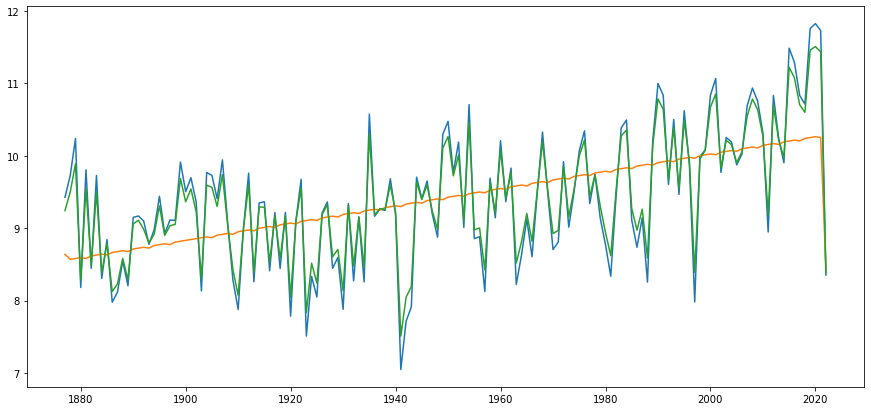

In [173]:
plt.figure(figsize=(15,7))
plt.plot(df_by_year.index, df_by_year.temp)
plt.plot(df_by_year.index, df_by_year['seasonal'])
plt.plot(df_by_year.index, df_by_year['full_predictions'])

## Checking model accuracy with time-series split

In [174]:
ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X_train, y_train)

result = cross_val_score(estimator=LR, 
                         X=X_train, y=y_train,
                         cv=time_series_split)

result

array([0.90481545, 0.91239141, 0.91355778, 0.90899072, 0.91791167])

In [175]:
result.mean()

0.9115334047270677

## Using both train and test as our dataset to predict the future

#### Concatening dataframes

In [176]:
# We'll concatenate the dataframes containing seasonal + remainder data 

X_full = pd.concat([df_with_seasonal, df_with_seasonal_test])
X_full = X_full.drop(columns=['seasonal', 'temp', 'full_predictions'])
y_full = pd.concat([y_train, y_test])

In [177]:
# We still have some NaN values in the test lag columns. We can fill that in easily with forwardfill

X_full.ffill(axis = 0, inplace=True)

In [178]:
X_full.head()

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,
1876-01-05,4,1,0,0,0,0,0,0,0,0,0,0,0,-8.928682,-4.928650,1.171383,3.371415,3.071448
1876-01-06,5,1,0,0,0,0,0,0,0,0,0,0,0,-6.828715,-8.928682,-4.928650,1.171383,3.371415
1876-01-07,6,1,0,0,0,0,0,0,0,0,0,0,0,-5.728748,-6.828715,-8.928682,-4.928650,1.171383
1876-01-08,7,1,0,0,0,0,0,0,0,0,0,0,0,-8.028780,-5.728748,-6.828715,-8.928682,-4.928650
1876-01-09,8,1,0,0,0,0,0,0,0,0,0,0,0,-11.828813,-8.028780,-5.728748,-6.828715,-8.928682


#### Creating a new row

In [179]:
# we can easily add the timestep and date

new_date_row_step = X_full.timestep.max() + 1
new_date_row_date = X_full.index.max() + timedelta(days=1)

# we first fill all the months with 0, then change the date month to 1 so we're consistent in our dummies
new_date_row_months = [0]*12
new_date_row_months[new_date_row_date.month-1] = 1

# we could calculate the remainder based on the first few columns but I'm being lazy and it is not necessary
# for one day predictions. I'll set it as nan
new_date_row_remainder = np.nan

# we set the lags to 0 for now, will modify them
new_date_row_lag = [0]*4

# now we can now put this all into an X_future list

X_future = [new_date_row_step]
X_future.extend(new_date_row_months)
X_future.append(new_date_row_remainder)
X_future.extend(new_date_row_lag)

In [180]:
# we append that list as a new row in the full dataframe

X_full.loc[new_date_row_date] = X_future

# and we fill in the lags based on the previous rows

add_lag_column(X_full, lag_list)
X_full.tail()

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,
2022-06-27,53503.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.897579,8.097612,5.697644,7.197677,5.397710
2022-06-28,53504.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.197546,9.897579,8.097612,5.697644,7.197677
2022-06-29,53505.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.197514,3.197546,9.897579,8.097612,5.697644
2022-06-30,53506.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.097481,3.197514,3.197546,9.897579,8.097612
2022-07-01,53507.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.097481,3.197514,3.197546,9.897579


In [191]:
X_full_train = X_full[4:-1]
y_full = y_full[4:]

X_full_test = X_full[-1:]

In [192]:
X_full_train

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,remainder,lag1,lag2,lag3,lag4
DATE,,,,,,,,,,,,,,,,,,
1876-01-09,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11.828813,-8.028780,-5.728748,-6.828715,-8.928682
1876-01-10,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.028846,-11.828813,-8.028780,-5.728748,-6.828715
1876-01-11,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.328878,-8.028846,-11.828813,-8.028780,-5.728748
1876-01-12,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.728911,-5.328878,-8.028846,-11.828813,-8.028780
1876-01-13,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.628944,-3.728911,-5.328878,-8.028846,-11.828813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,53502.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.097612,5.697644,7.197677,5.397710,3.097742
2022-06-27,53503.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.897579,8.097612,5.697644,7.197677,5.397710
2022-06-28,53504.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.197546,9.897579,8.097612,5.697644,7.197677


Figure(1080x576)


(-0.5, 1.25)

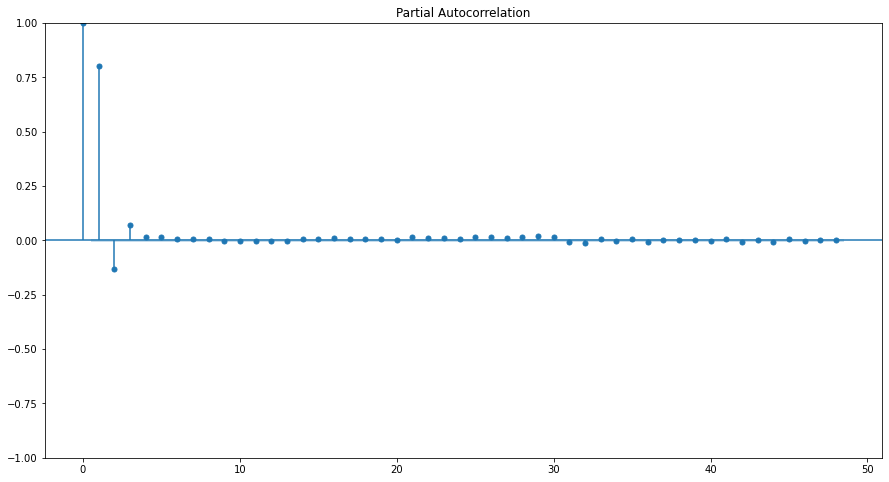

In [243]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure", figsize=(15,8))
print(plot_pacf(X_full_train['remainder'], method='ywm'))
ax.set_ylim([-0.5, 1.25])

In [230]:
from statsmodels.tsa.stattools import adfuller, kpss

adftest = adfuller(X_full_train['remainder'], autolag='AIC')

print('ADF Statistic: %f' % adftest[0])

print('p-value: %f' % adftest[1])

print('Critical Values:')

for key, value in adftest[4].items():
    print('\t%s: %.3f' % (key, value))
if adftest[0] < adftest[4]["5%"]:
    print ("Time Series is Non-Stationary")
else:
    print ("Time Series is Stationary")

ADF Statistic: -23.837209
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Time Series is Non-Stationary


From the graph, it looks like the optimal number of lags for p is 4. However, it looks like there might be an MA part

In [207]:
import pmdarima as pm

remainder_model = pm.auto_arima(
X_full_train['remainder'],
start_p=0,
max_p=4,
seasonality=False,
stationarity = True,
trace = True,
n_jobs=-1)

/Users/em/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=246082.751, Time=3.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=248167.392, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=248143.189, Time=1.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248129.525, Time=2.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=248165.393, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=27.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=244713.197, Time=5.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=32.30 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=243801.561, Time=9.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=51.44 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=243039.158, Time=17.59 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=56.96 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=243037.161, Time=6.40 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=243799.564, Time=3.78 sec
 ARIMA(1,1,5)(0,0,0)[0]     

In [206]:
remainder_model.predict(n_periods = 10, X=X_full_test)

array([4.37616013, 3.84995589, 3.74266719, 3.17866162, 2.91277232,
       2.91277232, 2.91277232, 2.91277232, 2.91277232, 2.91277232])

In [132]:
# we redefine our train and test sets

X_full = X_full.drop(columns = ['remainder'])

# for the training set we'll avoid the first values of the dataframe which are NaN and the last row which is our test
X_full_train = X_full[4:-1]
y_full = y_full[4:]

X_full_test = X_full[-1:]

In [133]:
# let's check that the shapes of our dataframes makes sense

X_full_train.shape, y_full.shape, X_full_test.shape

((53499, 17), (53499,), (1, 17))

In [134]:
# now we can fit our regression and make our predictions on the new row!

LR.fit(X_full_train, y_full)
y_pred = LR.predict(X_full_test)
y_pred

array([24.29116596])

## FULLER TEST

In [ ]:
## 

In [ ]:
remainder_model = pm.auto_arima(
train['f_remainder']),
start_p=0,
max_p=2,
seasonality=False
stationarity = True
trace = True,
n_jobs=-1
